In [1]:
import networkx as nx
import dwave_networkx as dnx
import random
import matplotlib.pyplot as plt
import pulp
import numpy as np

from lpSolver import solve
from uccgGenerator import tree_insertion, Graph
from plotNetwork import plotGraph, plotCoupling

In [2]:
def markov_chain_add_remove_simplicial(g_):
    g = Graph(g_)
    simplicial_vertices = filter(lambda v: dnx.is_simplicial(g, v), g.nodes)
    v = random.choice(list(simplicial_vertices))
    edges = set(g.edges(v))
    g.remove_edges_from(edges)
    g.remove_node(v)
    cliques = list(g.edges)
#     cliques.extend([[u] for u in g.nodes])
    c = random.sample(cliques, 1)[0]
    g.add_edges_from([(u, v) for u in c])
    return g, v, c

In [3]:
def get_children(g):
    simplicial_vertices = list(filter(lambda v: dnx.is_simplicial(g, v), g.nodes))
    N = len(simplicial_vertices)
    children = []
    visited = set()
    total_prob = 0
    self_loop = None
    for v in simplicial_vertices:
        cg = Graph(g)
        n = len(cg.nodes)
        edges = set(g.edges(v))
        cg.remove_edges_from(edges)
        cg.remove_node(v)
        cliques = list(cg.edges)
#         cliques.extend([[u] for u in cg.nodes])
        m = len(cliques)
        for c in cliques:
            g_child = Graph(cg)
            g_child.add_edges_from([(u, v) for u in c])
            g_simplicial_vertices = list(filter(lambda v: dnx.is_simplicial(g_child, v), g_child.nodes))
            if len(g_simplicial_vertices) != N or g_child in visited:
                continue
            visited.add(g_child)
            children.append(g_child)
            if g_child != g:
                g_child.prob = 1/(n*m)
                total_prob += g_child.prob
                g_child.move = f"reattach {v} to {c}"
            else:
                self_loop = g_child
                g_child.move = "stay"
    self_loop.prob = 1 - total_prob
    return children

In [4]:
def markov_chain_dist(g1, g2):
    visited = set()
    queue = [(g1, 0)]
    while queue:
        head, dist = queue.pop(0)
        if head == g2:
            return dist
        children = get_children(head)
        for child in children:
            if child not in visited:
                visited.add(child)
                queue.append((child, dist+1))
    return -1

In [5]:
g1 = tree_insertion(6, 9)
for _ in range(5):
    g1, _, _ = markov_chain_add_remove_simplicial(g1)

In [6]:
# g1 = Graph()
# g1.add_edges_from([(1, 2), (1,3), (3,2), (3,4), (2, 4), (3, 5), (4, 5)])
g2, v, c = markov_chain_add_remove_simplicial(g1)
markov_chain_dist(g1, g2)

1

/Users/wenbosun/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


reattach 4 to (0, 1)


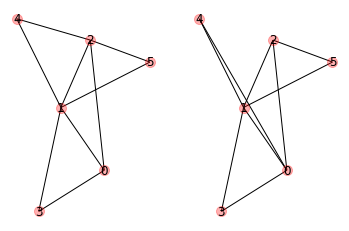

In [7]:
plt.figure()
plt.subplot(1,2,1)
plotGraph(g1)
plt.subplot(1,2,2)
plotGraph(g2, pos=nx.kamada_kawai_layout(g1))
print(f"reattach {v} to {c}")

In [8]:
g1_children = get_children(g1)
g2_children = get_children(g2)
l1, l2 = len(g1_children), len(g2_children)
print(l1, l2)

10 10


In [9]:
dists = np.zeros((l1, l2))
count = 0
for i in range(l1):
    for j in range(l2):
        dists[i][j] = markov_chain_dist(g1_children[i], g2_children[j])
        count += 1
        if count % 10 == 0:
            print(count)

10
20
30
40
50
60
70
80
90
100


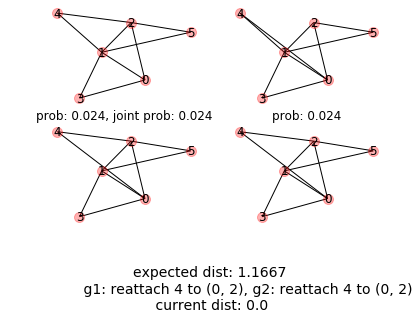

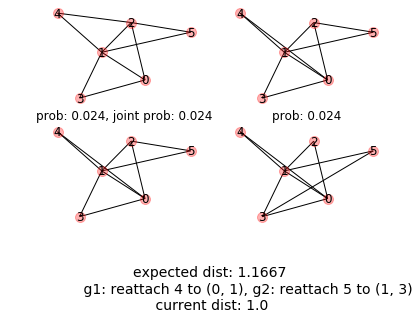

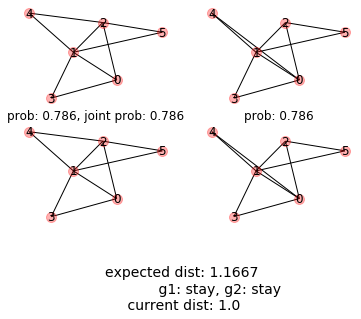

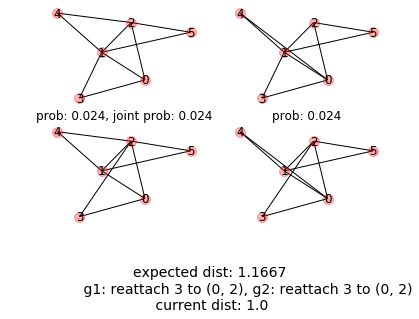

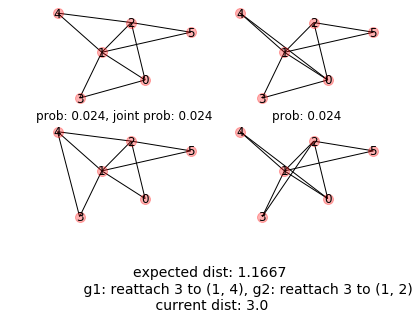

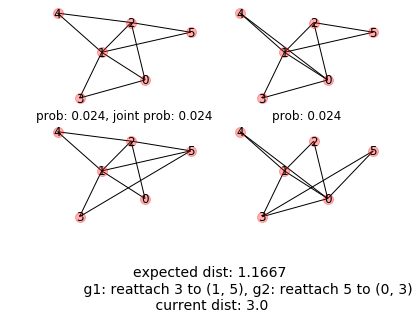

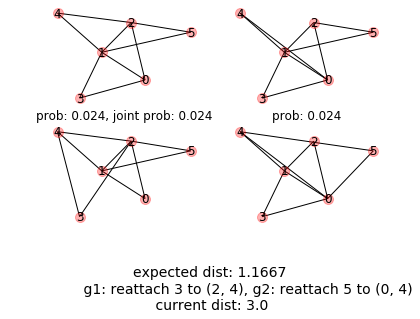

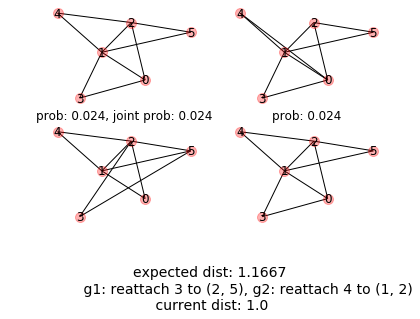

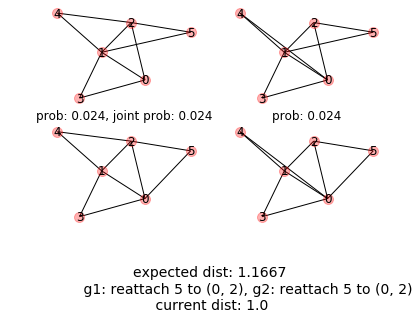

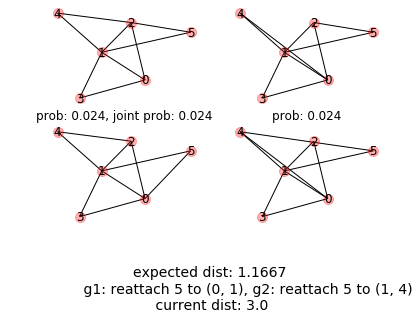

In [10]:
status, dist, joint_prob = solve(g1_children, g2_children, dists)
plotCoupling(g1, g2, g1_children, g2_children, dists, joint_prob, dist)
! rm *.png